**Step 0 - install and import dependencies**

In [22]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [23]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [24]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [25]:
df.tail()

,Review ID,Review
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...
299,300,ทรูคอฟฟี่สาขาซีคอนอยู่ในศูนย์บริการของทรู ชั้น...


**Step 1 - document embedding and dimension reduction**

In [26]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [27]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

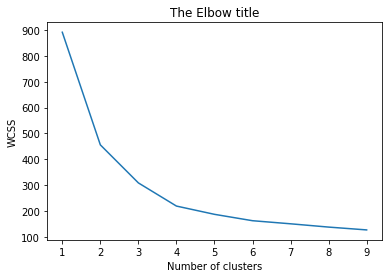

In [28]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [29]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [30]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [31]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [32]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [33]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [34]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [35]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [36]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [37]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [59]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'น', 'ร้า', 'น้ำ', 'ไทย',
                 'สวัสดี', 'ผม', 'ลอง', 'ดิฉัน', 'สาขา', 'รีวิว', 'กก', 'ซอย', 'มีโอกาส', 'กา', 'เมนู', 'ถนน', 'รี่', 
                 'ศ', 'ตั้งอยู่', 'แวะ', 'เจอ', 'คน', 'นึง', 'อ', 'นะคะ', 'าน', 'ไร้', 'ส', 'ครั้งแรก', 'แนว', 'ไหม',
                 'รา', 'เดิม', 'กร้าน', 'นขา', 'บอ', 'หา', 'เลือก', 'แถว', 'เติม', 'ชอบ', 'เม', 'ซอน', 'เก่าแก่', 'รอบ', 'กิน',
                 'ร', 'ห', 'นิว', 'ทาน', 'บ้าน', 'ร้านอาหาร']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "ชานมไข่มุก", "ชานม", "ชาไข่มุก", "อาหารเช้า", "บรรยากาศดี", "ราคาดี", "ร้านกาแฟ", "ร้านอาหาร", "อาหารเช้า"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [60]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [61]:
#results of tokenization
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(อร่อย, 6), (อาหาร, 6), (ราคา, 5), (เพื่อน, 4..."
1,1,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ, อาหาร, เ...","[(อร่อย, 9), (ร้านกาแฟ, 5), (กาแฟ, 5), (อาหาร,..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[Macchiato, เป็นประจำ, เด, ArtofCoffeeKasetsar...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (คาเฟ่, 6), (น่าร..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชานมไข่มุก, 9), (เครื่องดื่ม, 4), (ชาไข่มุก,..."


In [62]:
#show top keywords of each cluster

top_N_words = 8

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('อร่อย', 6), ('อาหาร', 6), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ยำ', 3)]

Cluster ID : 1

Most common words include : [('อร่อย', 9), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('คิว', 3), ('ซื้อ', 3), ('ดี', 3), ('เช้า', 2)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('คาเฟ่', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4)]

Cluster ID : 3

Most common words include : [('ชานมไข่มุก', 9), ('เครื่องดื่ม', 4), ('ชาไข่มุก', 4), ('ชา', 3), ('เดิน', 3), ('นม', 3), ('ไต้หวัน', 3), ('ชาเขียว', 2)]



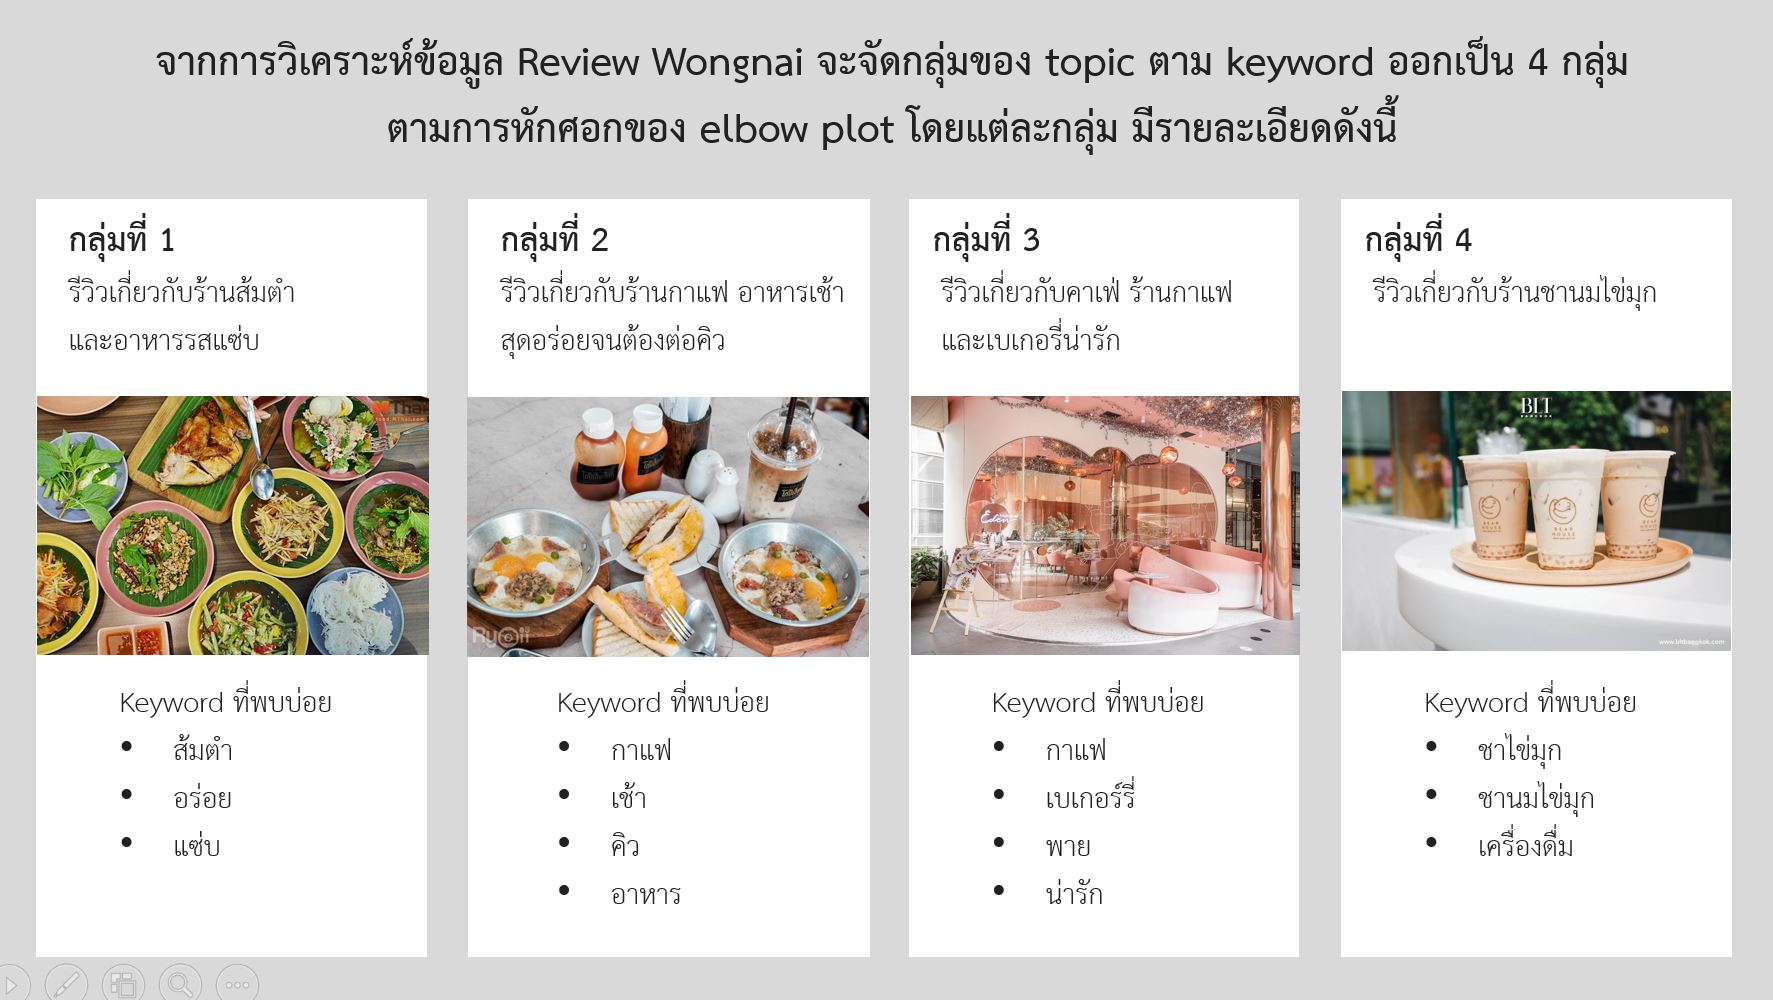